<a href="https://colab.research.google.com/github/malmong/nvidia-healthcare-assistant/blob/main/nvidia_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Libraries and Dependencies for AI Model Integration

In [ ]:
!pip install openai
!pip install OpenAI
!pip install requests
!pip install PyMuPDF
!pip install --upgrade --quiet llama-index-llms-nvidia llama-index-embeddings-nvidia llama-index-readers-file
!pip install llama-index-core
!pip install llama-index-readers-file
!pip install llama-index-llms-nvidia
!pip install llama-index-embeddings-nvidia
!pip install llama-index-postprocessor-nvidia-rerank
!pip install llama-parse
!pip install llama-index

Upload medical report PDF Files and Save

In [ ]:
from google.colab import files
import os

def upload_pdf_files():
    count = 1  # Counter for file names

    while True:
        # Upload a file
        print("Upload a PDF file (or click 'Stop' to end):")
        uploaded = files.upload()

        # Check if the upload was canceled
        if not uploaded:
            print("Upload stopped.")
            break

        for filename in uploaded.keys():
            if filename.endswith('.pdf'):  # Check if the file is a PDF
                # Assign a unique file name
                new_filename = f'/content/medical_report{count}.pdf'
                os.rename(filename, new_filename)
                print(f"File has been saved as: {new_filename}")
                count += 1  # Increment the count for the next file name
            else:
                print(f"The uploaded file is not a PDF. Skipping.")


Capture Photo Using Webcam and Save as File

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Python take_photo function
def take_photo(filename='photo.jpg', quality=0.8):
  # Start writing JavaScript
  js = Javascript('''
    async function takePhoto(quality) {

      // Create a div element
      const div = document.createElement('div');

      // Create a button element
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      // Create a video element
      const video = document.createElement('video');
      // Set the video style to display as a block
      video.style.display = 'block';
      // Access the camera (webcam)
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // Add div as a child element to the body
      document.body.appendChild(div);
      // Add video to the div
      div.appendChild(video);
      // Connect video with the webcam stream
      video.srcObject = stream;
      // Await to play the video asynchronously (related to threads) (async with await)
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for the Capture button to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      // Create a canvas element
      const canvas = document.createElement('canvas');
      // Set the canvas size
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      // Draw the video frame on the canvas
      canvas.getContext('2d').drawImage(video, 0, 0);
      // Stop the video stream
      stream.getVideoTracks()[0].stop();
      // Remove the div element
      div.remove();
      // Return the image as a base64-encoded string
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  # Execute the JavaScript and return the result to Python (basically this)
  data = eval_js('takePhoto({})'.format(quality))
  # The data is saved in base64 format in the browser, so decode it
  binary = b64decode(data.split(',')[1])
  # Save the binary data to a file
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


Image Label Extraction and Asset Upload with NVCF API

In [ ]:
import os
import uuid
import zipfile
import requests
import json
import shutil

# NVAI endpoint for the ocdrnet NIM
nvai_url = "https://ai.api.nvidia.com/v1/cv/nvidia/ocdrnet"

header_auth = f"Bearer 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"

def _upload_asset(input, description):
    """
    Uploads an asset to the NVCF API.
    :param input: The binary asset to upload
    :param description: A description of the asset
    """
    assets_url = "https://api.nvcf.nvidia.com/v2/nvcf/assets"

    headers = {
        "Authorization": header_auth,
        "Content-Type": "application/json",
        "accept": "application/json",
    }

    s3_headers = {
        "x-amz-meta-nvcf-asset-description": description,
        "content-type": "image/jpg",
    }

    payload = {"contentType": "image/jpg", "description": description}

    response = requests.post(assets_url, headers=headers, json=payload, timeout=30)
    response.raise_for_status()

    asset_url = response.json()["uploadUrl"]
    asset_id = response.json()["assetId"]

    response = requests.put(asset_url, data=input, headers=s3_headers, timeout=300)
    response.raise_for_status()

    return uuid.UUID(asset_id)

def clear_output_directory(directory):
    """Clears all files from the output directory."""
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")

def extract_labels_from_image(image_path: str, output_dir: str = "output_directory") -> list:
    """
    Processes an image, uploads it to the NVCF API, and extracts labels from the response.

    :param image_path: The file path of the image to process.
    :param output_dir: The directory to store the output files.
    :return: A list of extracted labels.
    """
    # Clear all files in the output directory
    clear_output_directory(output_dir)

    # Image upload
    with open(image_path, "rb") as img_file:
        asset_id = _upload_asset(img_file, "Input Image")

    inputs = {"image": f"{asset_id}", "render_label": True}
    asset_list = f"{asset_id}"

    headers = {
        "Content-Type": "application/json",
        "NVCF-INPUT-ASSET-REFERENCES": asset_list,
        "NVCF-FUNCTION-ASSET-IDS": asset_list,
        "Authorization": header_auth,
    }

    # API request
    response = requests.post(nvai_url, headers=headers, json=inputs)

    # Save and extract the zip file containing the results
    output_zip = f"{output_dir}.zip"
    with open(output_zip, "wb") as out:
        out.write(response.content)

    with zipfile.ZipFile(output_zip, "r") as z:
        z.extractall(output_dir)

    output_files = os.listdir(output_dir)

    # All responses in .response files
    all_responses = []  # List to store each response data

    for file_name in output_files:
        if file_name.endswith(".response"):
            response_file_path = os.path.join(output_dir, file_name)
            with open(response_file_path, "r") as response_file:
                try:
                    response_data = json.load(response_file)  # Parse JSON content
                    all_responses.append({"file": file_name, "content": response_data})
                except json.JSONDecodeError:
                    print(f"{file_name} is not a valid JSON file.")

    result_json = json.dumps(all_responses, indent=4)
    result_data = json.loads(result_json)

    # Extract labels from the responses
    labels = []
    for response_item in result_data:
        content = response_item.get("content")  # Access 'content' key
        if content and "metadata" in content:
            for item in content["metadata"]:
                if "label" in item:
                    labels.append(item["label"])

    return labels

pdf reader

In [ ]:
import fitz  # PyMuPDF

# Function for Allergy Skin Test Results Chart PDF to text
def pdf_to_text(pdf_path):
    """
    Converts a PDF file to text.
    :param pdf_path: The path to the PDF file.
    :return: A string containing the extracted text from the PDF.
    """
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(doc.page_count):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text

def convert_pdf_to_documents(pdf_path):
    """
    Converts a PDF file to a list of documents containing text.
    :param pdf_path: The path to the PDF file.
    :return: A list of dictionaries with the key 'text' containing the PDF content.
    """
    # Convert PDF to text
    pdf_text = pdf_to_text(pdf_path)

    # Return the text as a document
    documents = [{"text": pdf_text}]
    return documents


Food Consumption Recommendation Based on Documents and Labels

In [58]:
import getpass
import os
import nest_asyncio

from llama_index.llms.nvidia import NVIDIA
from llama_index.core.llms import ChatMessage, MessageRole

# Define the recommend_food_based_on_labels function
def recommend_food_based_on_labels(documents, labels):
    """
    This function provides a recommendation for food consumption based on the given documents and labels.
    It returns only the conclusion.
    """
    nest_asyncio.apply()

    # Set the NVIDIA API key
    os.environ["NVIDIA_API_KEY"] = "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"

    # Initialize the model
    llm = NVIDIA(model="nvidia/llama-3.1-nemotron-70b-instruct")

    # Create the message
    messages = [
        ChatMessage(
            role=MessageRole.SYSTEM, content=("You are a doctor.")
        ),
        ChatMessage(
            role=MessageRole.USER,
            content=(f"Based on the following documents {documents}, tell me whether consuming food containing {labels} is recommended."),
        ),
    ]

    # Send the message to the model and get a response
    response = llm.chat(messages)

    # Extract only the conclusion from the response
    if response and response.message:
        conclusion = response.message.content.split("\n")[-1]  # Extract the last line as the conclusion
        return response
    else:
        return "No response received."

Summarizing Food Consumption Recommendations Based on Medical Reports

In [59]:
def recommend_food_based_on_labels_last(all_recommendations):
    """
    This function takes the recommendations from multiple documents and processes them to return
    a summary of food recommendations in a dictionary format.
    """
    nest_asyncio.apply()

    # Set the NVIDIA API key
    os.environ["NVIDIA_API_KEY"] = "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"

    # Initialize the model
    llm = NVIDIA(model="nvidia/llama-3.1-nemotron-70b-instruct")

    # Initialize the dictionary to store results
    recommendations_summary = {}

    for pdf_file, recommendation in all_recommendations.items():
        # Create the message
        messages = [
            ChatMessage(
                role=MessageRole.SYSTEM, content=("You are a doctor.")
            ),
            ChatMessage(
                role=MessageRole.USER,
                content=(f"{recommendation}\nThis text is an evaluation of the food I plan to consume, based on my medical report. "
                         "Summarize whether it is good or bad for my health in three lines, based on all the PDFs. "
                         "If there is no relevant information, it's okay to consume the food."),
            ),
        ]

        # Send the message to the model and get a response
        response = llm.chat(messages)

        # Extract only the conclusion from the response
        if response and response.message:
            conclusion = response.message.content.split("\n")[-1]  # Extract the last line as the conclusion
            recommendations_summary[pdf_file] = conclusion
        else:
            recommendations_summary[pdf_file] = "Unable to receive a response."

    return recommendations_summary


main code(with camera)

No PDF files found. Please upload the PDF files.
Upload a PDF file (or click 'Stop' to end):


Saving allergy_sample.pdf to allergy_sample.pdf
File has been saved as: /content/medical_report1.pdf
Upload a PDF file (or click 'Stop' to end):


Saving normal-blood-sugar-levels-chart-sample.pdf to normal-blood-sugar-levels-chart-sample.pdf
File has been saved as: /content/medical_report2.pdf
Upload a PDF file (or click 'Stop' to end):


Upload stopped.


<IPython.core.display.Javascript object>

Saved to photo.jpg


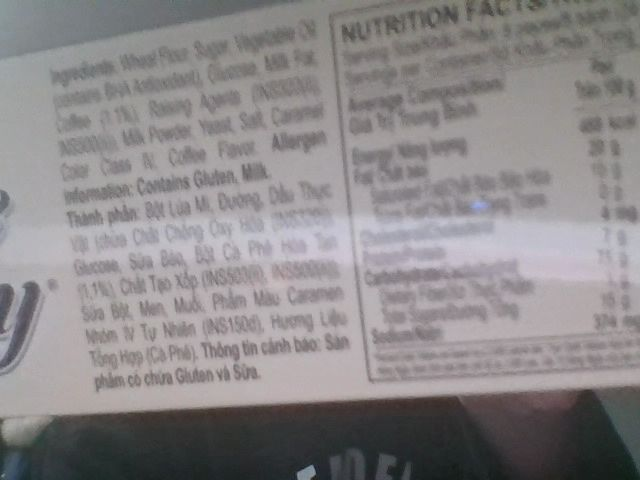


Processing medical_report1.pdf...

Processing medical_report2.pdf...

Updated All Recommendations:
medical_report1.pdf: Based on your medical report, it is not recommended to consume the food containing peanuts due to a severe allergy. However, there is no indication of a gluten allergy or intolerance. The other ingredients do not appear to pose a risk based on the provided information.
medical_report2.pdf: Based on the evaluation, the food you plan to consume appears to be bad for your health due to the presence of gluten and other ingredients that don't align with the recommended diet for managing blood sugar levels. The ingredients may also be problematic for individuals with dietary restrictions or preferences. It's recommended to choose whole, nutrient-dense foods instead.


In [ ]:
import os
from IPython.display import Image

nvidia_api_key = "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"

# Directory path where the PDF files are stored
pdf_directory = '/content/'

# Get a list of all PDF files starting with 'medical_report'
pdf_files = sorted([f for f in os.listdir(pdf_directory) if f.startswith('medical_report') and f.endswith('.pdf')])

# Function to determine the next available report filename
def get_next_report_filename():
    if not pdf_files:
        return 'medical_report1.pdf'  # If no files exist, return the first file name
    else:
        # Find the highest number in the existing files and calculate the next number
        existing_numbers = [int(f.split('medical_report')[1].split('.pdf')[0]) for f in pdf_files]
        next_number = max(existing_numbers) + 1
        return f'medical_report{next_number}.pdf'

# If PDF files exist, ask whether to upload additional files
if pdf_files:
    print(f"Existing PDF files: {pdf_files}")
    user_choice = input("Do you want to upload additional PDF files? (yes/no): ").strip().lower()
    if user_choice == 'yes':
        uploaded_files = files.upload()  # Upload new files
        for filename in uploaded_files.keys():
            if filename.endswith('.pdf'):
                new_filename = os.path.join(pdf_directory, get_next_report_filename())
                os.rename(filename, new_filename)
                pdf_files.append(new_filename)
                print(f"File has been saved as: {new_filename}")
    elif user_choice == 'no':
        print("Proceeding with existing PDF files.")
    else:
        print("Invalid input. Proceeding with existing PDF files.")

# If no PDF files exist, prompt the user to upload files
else:
    print("No PDF files found. Please upload the PDF files.")
    upload_pdf_files()
    # After uploading, refresh the list of PDF files
    pdf_files = sorted([f for f in os.listdir(pdf_directory) if f.startswith('medical_report') and f.endswith('.pdf')])

# Initialize the variable to accumulate recommendations
all_recommendations = {}

try:

    # Take a photo
    filename = take_photo()
    print('Saved to {}'.format(filename))

    # Display the taken photo
    display(Image(filename))


    # Set the image path
    image_path = "/content/photo.jpg"

    # Extract labels from the image
    labels = extract_labels_from_image(image_path)

    # Generate recommendations for each PDF file
    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_directory, pdf_file)
        print(f"\nProcessing {pdf_file}...")

        # Convert PDF file to documents
        documents = convert_pdf_to_documents(pdf_path)

        # Generate recommendations based on labels
        recommendation = recommend_food_based_on_labels(documents, labels)

        # Accumulate recommendations
        all_recommendations[pdf_file] = recommendation

        # Each medical report's recommendation
        #print(f"Recommendation for {pdf_file}: {recommendation}")

except Exception as err:
    # Display error message if web camera permission is denied or camera is not available
    print(str(err))

# Process all PDF file recommendations at once using a function
try:
    # Call the recommend_food_based_on_labels_last function to update all recommendations at once
    # This function should return the results as a dictionary.
    updated_recommendations = recommend_food_based_on_labels_last(all_recommendations)

    # Check if the function returns a dictionary
    if isinstance(updated_recommendations, dict):
        # Print updated recommendations
        print("\nUpdated All Recommendations:")
        for pdf_file, updated_recommendation in updated_recommendations.items():
            print(f"{pdf_file}: {updated_recommendation}")
    else:
        print("Error: The function did not return a dictionary. Please check the function's implementation.")

except Exception as err:
    print(f"Error processing recommendations: {str(err)}")


main code(without camera) (you must upload photo2.jpg on content)

In [ ]:
import os
from IPython.display import Image

# Directory path where the PDF files are stored
pdf_directory = '/content/'

nvidia_api_key = "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"

# Get a list of all PDF files starting with 'medical_report'
pdf_files = sorted([f for f in os.listdir(pdf_directory) if f.startswith('medical_report') and f.endswith('.pdf')])

# Function to determine the next available report filename
def get_next_report_filename():
    if not pdf_files:
        return 'medical_report1.pdf'  # If no files exist, return the first file name
    else:
        # Find the highest number in the existing files and calculate the next number
        existing_numbers = [int(f.split('medical_report')[1].split('.pdf')[0]) for f in pdf_files]
        next_number = max(existing_numbers) + 1
        return f'medical_report{next_number}.pdf'

# If PDF files exist, ask whether to upload additional files
if pdf_files:
    print(f"Existing PDF files: {pdf_files}")
    user_choice = input("Do you want to upload additional PDF files? (yes/no): ").strip().lower()
    if user_choice == 'yes':
        uploaded_files = files.upload()  # Upload new files
        for filename in uploaded_files.keys():
            if filename.endswith('.pdf'):
                new_filename = os.path.join(pdf_directory, get_next_report_filename())
                os.rename(filename, new_filename)
                pdf_files.append(new_filename)
                print(f"File has been saved as: {new_filename}")
    elif user_choice == 'no':
        print("Proceeding with existing PDF files.")
    else:
        print("Invalid input. Proceeding with existing PDF files.")

# If no PDF files exist, prompt the user to upload files
else:
    print("No PDF files found. Please upload the PDF files.")
    upload_pdf_files()
    # After uploading, refresh the list of PDF files
    pdf_files = sorted([f for f in os.listdir(pdf_directory) if f.startswith('medical_report') and f.endswith('.pdf')])

# Initialize the variable to accumulate recommendations
all_recommendations = {}

try:

    # Set the image path
    image_path = "/content/photo2.jpg"

    # Extract labels from the image
    labels = extract_labels_from_image(image_path)

    # Generate recommendations for each PDF file
    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_directory, pdf_file)
        print(f"\nProcessing {pdf_file}...")

        # Convert PDF file to documents
        documents = convert_pdf_to_documents(pdf_path)

        # Generate recommendations based on labels
        recommendation = recommend_food_based_on_labels(documents, labels)

        # Accumulate recommendations
        all_recommendations[pdf_file] = recommendation

        # Each medical report's recommendation
        #print(f"Recommendation for {pdf_file}: {recommendation}")

except Exception as err:
    # Display error message if web camera permission is denied or camera is not available
    print(str(err))

# Process all PDF file recommendations at once using a function
try:
    # Call the recommend_food_based_on_labels_last function to update all recommendations at once
    # This function should return the results as a dictionary.
    updated_recommendations = recommend_food_based_on_labels_last(all_recommendations)

    # Check if the function returns a dictionary
    if isinstance(updated_recommendations, dict):
        # Print updated recommendations
        print("\nUpdated All Recommendations:")
        for pdf_file, updated_recommendation in updated_recommendations.items():
            print(f"{pdf_file}: {updated_recommendation}")
    else:
        print("Error: The function did not return a dictionary. Please check the function's implementation.")

except Exception as err:
    print(f"Error processing recommendations: {str(err)}")


Existing PDF files: ['medical_report1.pdf', 'medical_report2.pdf']
Do you want to upload additional PDF files? (yes/no): no
Proceeding with existing PDF files.

Processing medical_report1.pdf...

Processing medical_report2.pdf...

Updated All Recommendations:
medical_report1.pdf: Based on your medical report, consuming the food containing peanuts or peanut products is extremely bad for your health. You have a severe peanut allergy, and exposure to peanuts poses a significant risk of anaphylaxis. I strongly advise against consuming this food to prioritize your safety.
medical_report2.pdf: Based on your medical report, consuming the listed food ingredients is not recommended as it can be detrimental to your blood sugar control and overall health. The ingredients are high in sugar, salt, and unhealthy fats, which can increase the risk of heart disease and worsen insulin resistance. It is advised to opt for healthier alternatives that align with your recommended dietary plan.
